# Week 3
## Data Preprocessing

In this task, we will Pre-Process the given datasets.

In [286]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [287]:
airq = pd.read_csv('data/airq402.csv')
wine_red = pd.read_csv('data/winequality-red.csv', sep=';')
wine_white = pd.read_csv('data/winequality-white.csv', sep=';')

Before we start with the exercise, we rename the columns of the airq dataset according to https://users.stat.ufl.edu/~winner/data/airq402.txt

In [288]:
airq.columns = [
    "City1",  # Origin city
    "City2",  # Destination city
    "Average_Fare",  # Average fare (USD)
    "Distance",  # Distance (miles)
    "Avg_Weekly_Passengers",  # Average weekly passengers
    "Leading_Airline",  # Market leading airline
    "Leading_Share",  # Market share of leading airline (%)
    "Leading_Fare",  # Average fare for leading airline (USD)
    "Low_Price_Airline",  # Low price airline
    "Low_Price_Share",  # Market share of low price airline (%)
    "Low_Price_Fare"  # Price for low price airline (USD)
]

Now, we start with the exercise and convert all values to numeric values using `pandas.get_dummies`. For the airq dataset, we use pd.get_dummies() to "convert every categorical variable into indicator variable. Each variable is converted in as many 0/1 variables as there are different values. Columns in the output are each named after a value; if the input is a DataFrame, the name of the original variable is prepended to the value" (https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html#pandas.get_dummies).
This gives us the one-hot encoding required according to the question.


In [289]:
airq = pd.get_dummies(airq).astype(np.float64)

We handle sparse data / missing values. Looking over the datasets by eye, we do not see any missing values. Since we have quite large datasets and, we can just drop the columns with missing values. As we can see from the execution, there are actually no missing values in the dataset.

In [290]:
print(f'len of winequality_red before: {len(wine_red)}')
wine_red = wine_red.dropna()
print(f'len of winequality_red after: {len(wine_red)}\n')

print(f'len of winequality_white before: {len(wine_white)}')
wine_white = wine_white.dropna()
print(f'len of winequality_white after: {len(wine_white)}\n')

print(f'len of airq before: {len(airq)}')
airq = airq.dropna()
print(f'len of winequality_white after: {len(airq)}\n')

len of winequality_red before: 1599
len of winequality_red after: 1599

len of winequality_white before: 4898
len of winequality_white after: 4898

len of airq before: 1000
len of winequality_white after: 1000



We use `pandas.DataFrame.sample` like last week to split the datasets in training data and test data.

In [291]:
airq_train = airq.sample(frac=0.8, random_state=69)
airq_test = airq.drop(airq_train.index)

wine_red_train = wine_red.sample(frac=0.8, random_state=69)
wine_red_test = wine_red.drop(wine_red_train.index)

wine_white_train = wine_white.sample(frac=0.8, random_state=69)
wine_white_test = wine_white.drop(wine_white_train.index)

## Linear Regression with Gradient Descent

In this task, we implement a linear regression algorithm with gradient descent.

Additionally, to the algorithm on the exercise sheet, we implemented gradient clipping like Maksim suggested in the forum to prevent overshooting.


In [292]:
class LinRegGradDesc:
    def __init__(self):
        self.B = None
        self.loss_history = []
        self.rmse_history = []

    def fit(self, X, y, alpha, i_max, epsilon, step_length_function=None):
        """
        Learn Linear Regression via Loss Minimization via Gradient Descent.
        :param X: Input features.
        :param y: Target values.
        :param alpha: Step length.
        :param i_max: Maximum number of iterations.
        :param epsilon: Convergence threshold.
        :param step_length_function: Gradient descent step length function.
        :return: None
        """
        self.loss_history = []
        self.rmse_history = []
        self.B = self._minimize_gd(X, y, alpha, i_max, epsilon, step_length_function)
        return self.loss_history, self.rmse_history

    def predict(self, X):
        """
        Predict using the linear regression model.
        :param X: Input features to predict values for.
        :return: Predicted values.
        """
        if self.B is None:
            raise ValueError("The model has not been trained yet. Please call fit() first.")

        return (X @ self.B).reshape(-1, 1)

    def _minimize_gd(self, X, y, alpha, i_max, epsilon, step_length_function, clip_value=0.1):
        """
        Minimize loss using gradient descent.
        :param X: Input features.
        :param y: Target values.
        :param alpha: Step length.
        :param i_max: Maximum number of iterations.
        :param epsilon: Convergence threshold.
        :param step_length_function: Gradient descent step length function.
        :param clip_value: Clipping value.
        :return: Optimal weights.
        """

        f = lambda B: ((y - X @ B).T @ (y - X @ B)).ravel()
        x_i = np.zeros((X.shape[1], 1))

        for i in range(1, i_max + 1):
            d = 2 * X.T @ (y - X @ x_i) / len(y)  # Analytical Gradient

            # handle gradient clipping
            d_norm = np.linalg.norm(d)
            if d_norm > clip_value:
                d = (d / d_norm) * clip_value

            if step_length_function == 'armijo':
                alpha_i = self._armijo(f, x_i, d)
            elif step_length_function == 'bolddriver':
                alpha_i = self._bolddriver(f, x_i, d, alpha)
            else:
                alpha_i = alpha

            x_i_new = x_i + alpha_i * d

            loss = f(x_i) - f(x_i_new)
            self.loss_history.append(loss)

            rmse = np.sqrt(np.mean((y - X @ x_i_new) ** 2))
            self.rmse_history.append(rmse)

            if np.abs(loss) < epsilon:
                print(f'Converged in {i} iterations.')
                return x_i_new

            x_i = x_i_new

        # raise ValueError(f'Did not converge in {i_max} iterations')

        print(f'Did not converge in {i_max} iterations')
        return x_i

    @staticmethod
    def _armijo(f, x, d, delta=0.2):
        """
        Armijo step length function.
        :param f: Loss function.
        :param x: Last position.
        :param d: Descent directions.
        :param delta: Minimum steepness
        :return: Step length alpha.
        """
        alpha = 1

        while f(x) - f(x + alpha * d) < alpha * delta * d.T @ d:
            alpha /= 2

        return alpha

    @staticmethod
    def _bolddriver(f, x, d, alpha_old, alpha_plus=1.1, alpha_minus=0.5):
        """
        Bold driver step length function.
        :param f: Loss function.
        :param x: Last position.
        :param d: Descent directions.
        :param alpha_old: Last step length.
        :param alpha_plus: Step length increase factor.
        :param alpha_minus: Step length decrease factor.
        :return: Step length alpha.
        """
        alpha = alpha_old * alpha_plus

        while (f(x) - f(x + alpha * d)) <= 0:
            alpha = alpha * alpha_minus

        return alpha


### A: Fixed step lentgh
Now, we use the model to plot the loss against the iteration nuber i and to plot the RMSE for the airq dataset.
We have to choose a very high convergence threshold of 50, because for epsilon < 1, it takes > 3000 iterations for this model and dataset. For the step size, we choose 0.001, 0.01 and 0.1. We cannot choose any higher step sizes, because the model is very unstable even with gradient clipping.

Did not converge in 1000 iterations
Did not converge in 1000 iterations
Converged in 644 iterations.


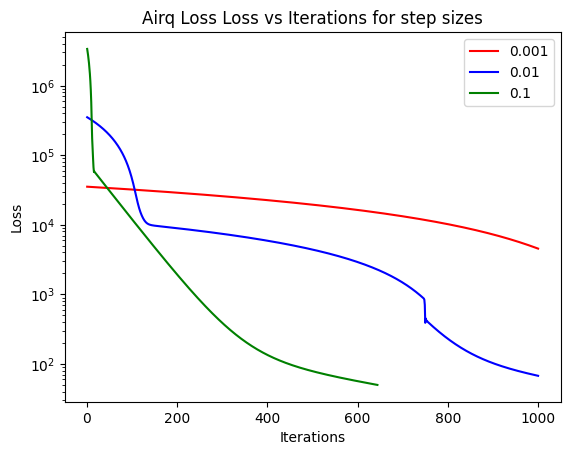

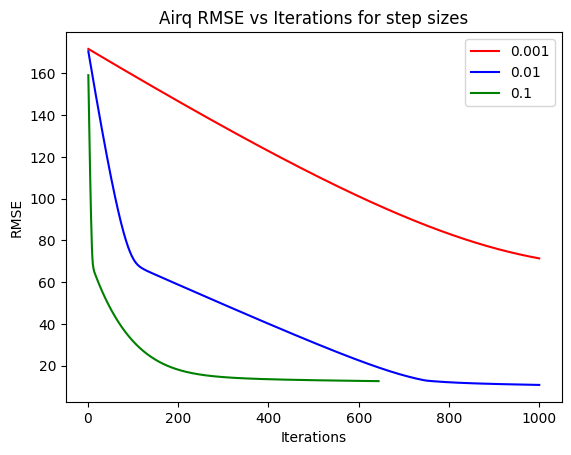

In [293]:
model = LinRegGradDesc()

airq_train_X = airq_train.drop('Average_Fare', axis=1).to_numpy()
airq_train_y = airq_train['Average_Fare'].to_numpy().reshape(-1, 1)

loss_0, rmse_0 = model.fit(airq_train_X, airq_train_y, alpha=0.001, i_max=1000, epsilon=50)
loss_1, rmse_1 = model.fit(airq_train_X, airq_train_y, alpha=0.01, i_max=1000, epsilon=50)
loss_2, rmse_2 = model.fit(airq_train_X, airq_train_y, alpha=0.1, i_max=1000, epsilon=50)

plt.plot(range(1, len(loss_0) + 1), loss_0, label='0.001', color='red')
plt.plot(range(1, len(loss_1) + 1), loss_1, label='0.01', color='blue')
plt.plot(range(1, len(loss_2) + 1), loss_2, label='0.1', color='green')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Airq Loss Loss vs Iterations for step sizes')
plt.legend()
plt.show()
plt.close()

plt.plot(range(1, len(rmse_0) + 1), rmse_0, label='0.001', color='red')
plt.plot(range(1, len(rmse_1) + 1), rmse_1, label='0.01', color='blue')
plt.plot(range(1, len(rmse_2) + 1), rmse_2, label='0.1', color='green')

plt.xlabel('Iterations')
plt.ylabel('RMSE')
# plt.yscale('log')
plt.title('Airq RMSE vs Iterations for step sizes')
plt.legend()
plt.show()
plt.close()

*Loss vs Iterations*
- *$\alpha = 0.001$*: Slow and steady reduction in loss, stable but needs more iterations to converge.
- *$\alpha = 0.01$*: Faster initial drop, needs just a few more iterations to converge.
- *$\alpha = 0.1$*: Fast initial drop, converges after 644 iterations.

*RMSE vs Iterations*
- *$\alpha = 0.001$*: Gradual reduction in RMSE, converges very slowly.
- *$\alpha = 0.01$*: Faster and stable, consistently lower error.
- *$\alpha = 0.1$*: Very fast drop, stabilizes quickly.

Now, we do the same for the winequality-red dataset. For the convergence threshold we use $\epsilon = 1$

Did not converge in 1000 iterations
Converged in 474 iterations.
Converged in 420 iterations.


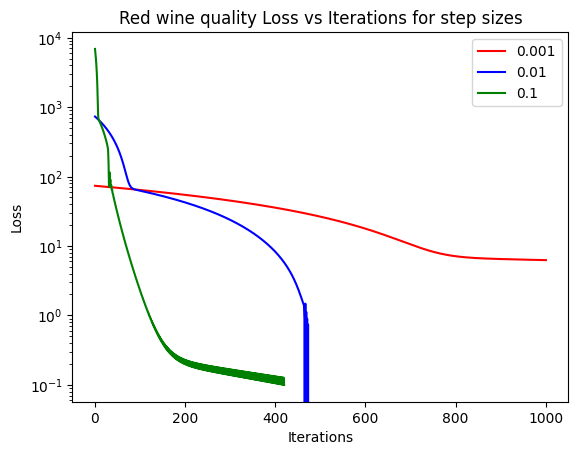

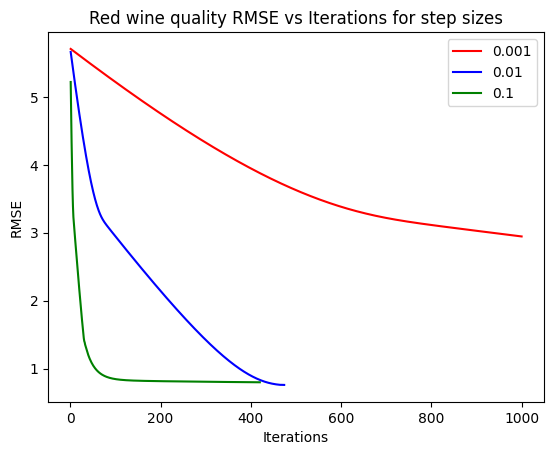

In [294]:
model = LinRegGradDesc()

wine_red_train_X = wine_red_train.drop('quality', axis=1).to_numpy()
wine_red_train_y = wine_red_train['quality'].to_numpy().reshape(-1, 1)

loss_0, rmse_0 = model.fit(wine_red_train_X, wine_red_train_y, alpha=0.001, i_max=1000, epsilon=0.1)
loss_1, rmse_1 = model.fit(wine_red_train_X, wine_red_train_y, alpha=0.01, i_max=1000, epsilon=0.1)
loss_2, rmse_2 = model.fit(wine_red_train_X, wine_red_train_y, alpha=0.1, i_max=1000, epsilon=0.1)

plt.plot(range(1, len(loss_0) + 1), loss_0, label='0.001', color='red')
plt.plot(range(1, len(loss_1) + 1), loss_1, label='0.01', color='blue')
plt.plot(range(1, len(loss_2) + 1), loss_2, label='0.1', color='green')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Red wine quality Loss vs Iterations for step sizes')
plt.legend()
plt.show()
plt.close()

plt.plot(range(1, len(rmse_0) + 1), rmse_0, label='0.001', color='red')
plt.plot(range(1, len(rmse_1) + 1), rmse_1, label='0.01', color='blue')
plt.plot(range(1, len(rmse_2) + 1), rmse_2, label='0.1', color='green')

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Red wine quality RMSE vs Iterations for step sizes')
plt.legend()
plt.show()
plt.close()

This is amost the same as before. We see a better overall convergence.
for $\alpha = 0.1$, we can see some instability at around 100 iterations, but it manages to reach low values quickly. Just before reaching the convergence threshold, the curve widens. This widening indicates that the model is experiencing overshooting or oscillations due to the high step size.

Now, we do the same for the white wine dataset.

Did not converge in 1000 iterations
Did not converge in 1000 iterations
Did not converge in 1000 iterations


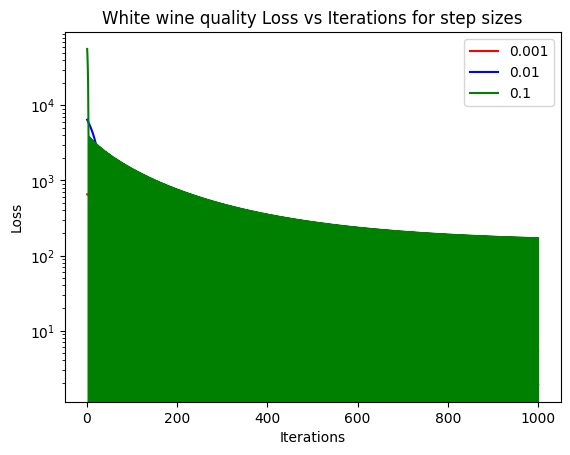

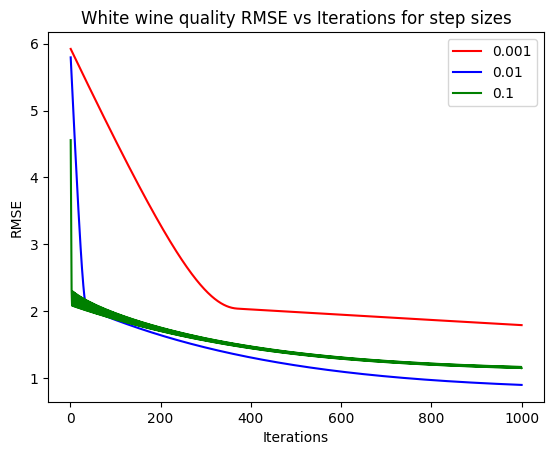

In [295]:
model = LinRegGradDesc()

wine_white_train_X = wine_white_train.drop('quality', axis=1).to_numpy()
wine_white_train_y = wine_white_train['quality'].to_numpy().reshape(-1, 1)

loss_0, rmse_0 = model.fit(wine_white_train_X, wine_white_train_y, alpha=0.001, i_max=1000, epsilon=1)
loss_1, rmse_1 = model.fit(wine_white_train_X, wine_white_train_y, alpha=0.01, i_max=1000, epsilon=1)
loss_2, rmse_2 = model.fit(wine_white_train_X, wine_white_train_y, alpha=0.1, i_max=1000, epsilon=1)

plt.plot(range(1, len(loss_0) + 1), loss_0, label='0.001', color='red')
plt.plot(range(1, len(loss_1) + 1), loss_1, label='0.01', color='blue')
plt.plot(range(1, len(loss_2) + 1), loss_2, label='0.1', color='green')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('White wine quality Loss vs Iterations for step sizes')
plt.legend()
plt.show()
plt.close()

plt.plot(range(1, len(rmse_0) + 1), rmse_0, label='0.001', color='red')
plt.plot(range(1, len(rmse_1) + 1), rmse_1, label='0.01', color='blue')
plt.plot(range(1, len(rmse_2) + 1), rmse_2, label='0.1', color='green')

plt.xlabel('Iterations')
plt.ylabel('RMSE')
# plt.yscale('log')
plt.title('White wine quality RMSE vs Iterations for step sizes')
plt.legend()
plt.show()
plt.close()

Here, we see that the gradient descent with step size 0.1 suffers heavily from overshooting. This happens even though we use gradient clipping, as the updates are still too aggressive, causing the loss to oscillate. This overshooting behavior indicates that even clipped gradients can push the model too far from the optimal point when the step size is too large, leading to instability in convergence.

Despite my attempts to optimize the model and prevent overshooting, it still seems inefficient and struggles to converge reliably.

### B: Dynamic step length

Now, we compare the steplength-armijo and steplength-bolddriver algorithms to three fixed step lengths.

Did not converge in 1000 iterations
Converged in 474 iterations.
Converged in 420 iterations.
Converged in 112 iterations.
Converged in 742 iterations.
Converged in 472 iterations.


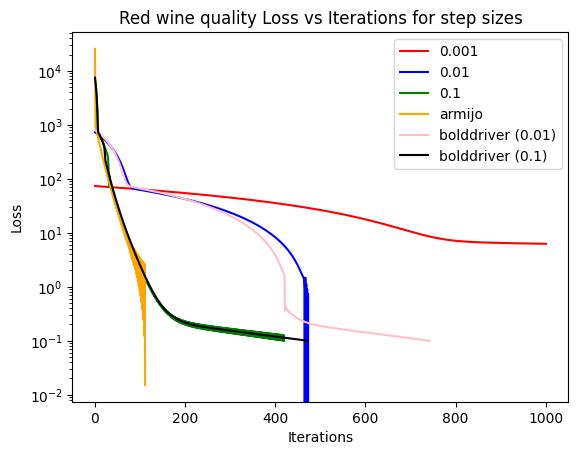

In [299]:
model = LinRegGradDesc()

wine_red_train_X = wine_red_train.drop('quality', axis=1).to_numpy()
wine_red_train_y = wine_red_train['quality'].to_numpy().reshape(-1, 1)

loss_0, rmse_0 = model.fit(wine_red_train_X, wine_red_train_y, alpha=0.001, i_max=1000, epsilon=0.1)
loss_1, rmse_1 = model.fit(wine_red_train_X, wine_red_train_y, alpha=0.01, i_max=1000, epsilon=0.1)
loss_2, rmse_2 = model.fit(wine_red_train_X, wine_red_train_y, alpha=0.1, i_max=1000, epsilon=0.1)
loss_armijo, rmse_armijo = model.fit(wine_red_train_X, wine_red_train_y, alpha=0.01, i_max=1000, epsilon=0.1,
                                     step_length_function='armijo')
loss_bolddriver_0, rmse_bolddriver_0 = model.fit(wine_red_train_X, wine_red_train_y, alpha=0.01, i_max=1000,
                                                 epsilon=0.1,
                                                 step_length_function='bolddriver')
loss_bolddriver_1, rmse_bolddriver_1 = model.fit(wine_red_train_X, wine_red_train_y, alpha=0.1, i_max=1000,
                                                 epsilon=0.1,
                                                 step_length_function='bolddriver')

plt.plot(range(1, len(loss_0) + 1), loss_0, label='0.001', color='red')
plt.plot(range(1, len(loss_1) + 1), loss_1, label='0.01', color='blue')
plt.plot(range(1, len(loss_2) + 1), loss_2, label='0.1', color='green')
plt.plot(range(1, len(loss_armijo) + 1), loss_armijo, label='armijo', color='orange')
plt.plot(range(1, len(loss_bolddriver_0) + 1), loss_bolddriver_0, label='bolddriver (0.01)', color='pink')
plt.plot(range(1, len(loss_bolddriver_1) + 1), loss_bolddriver_1, label='bolddriver (0.1)', color='black')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Red wine quality Loss vs Iterations for step sizes')
plt.legend()
plt.show()
plt.close()




The Armijo method quickly drives the loss down to a very low value, showing that it effectively adapts to minimize loss aggressively in the beginning. However, the aggressive adaptation results in overshooting, which the algorithm eventually corrects by adjusting the step size. This allows it to converge the fastest overall.

The Bold Driver approach initially shows a smooth decline but experiences several fluctuations throughout the convergence process. The performance seems highly dependent on the initial alpha value, indicating that this method requires careful tuning of the initial step size.

Overall, Armijo adapts effectively to overshooting, allowing it to stabilize quickly after early fluctuations, while Bold Driver struggles more with its dependence on the initial alpha.

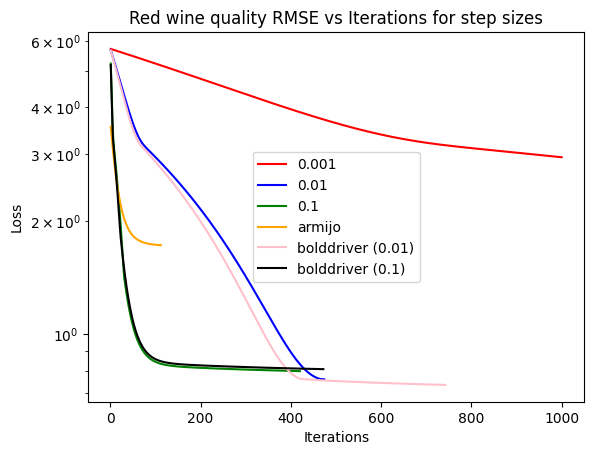

In [300]:
plt.plot(range(1, len(rmse_0) + 1), rmse_0, label='0.001', color='red')
plt.plot(range(1, len(rmse_1) + 1), rmse_1, label='0.01', color='blue')
plt.plot(range(1, len(rmse_2) + 1), rmse_2, label='0.1', color='green')
plt.plot(range(1, len(rmse_armijo) + 1), rmse_armijo, label='armijo', color='orange')
plt.plot(range(1, len(rmse_bolddriver_0) + 1), rmse_bolddriver_0, label='bolddriver (0.01)', color='pink')
plt.plot(range(1, len(rmse_bolddriver_1) + 1), rmse_bolddriver_1, label='bolddriver (0.1)', color='black')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Red wine quality RMSE vs Iterations for step sizes')
plt.legend()
plt.show()
plt.close()

Armijo shows a well-balanced performance by quickly lowering RMSE and adapting to maintain stability without oscillations. Its adaptive strategy allows for efficient convergence without the reliance on precise initial settings.

Bold Driver again relies heavily on the initial step size to determine convergence quality. With an initial alpha of 0.01, it converges steadily but slower compared to Armijo, while an initial alpha of 0.1 leads to rapid improvement but less efficient stabilization. This dependence makes Bold Driver less consistent in achieving optimal results, highlighting the importance of tuning the initial parameters effectively.
